In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.PINNnet import PINN
#from utils.plot_func import plot_field, model_pred, plot_error_field, plot_loss
from utils.plot_func import plot_field
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
## hyperparameter
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5

In [3]:
import joblib
state_dict = joblib.load('model_line.joblib')
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
model = model.to(device)

In [5]:
def model_pred(model, Lx, Ly, N=100):
    x, y = torch.linspace(-Lx, Lx, N), torch.linspace(-Ly, Ly, N)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    model = model.to('cpu')
    inputs = torch.cat([x, y], dim=-1)
    p_real = model(inputs)[:, 0].detach().numpy()
    p_imag = model(inputs)[:, 1].detach().numpy()
    p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_real, levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('PINN (real)')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1, 2, 2)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_imag, levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('PINN (imag)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('PINN.jpg')
    

/home/zhufanjie/miniconda3/envs/work/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


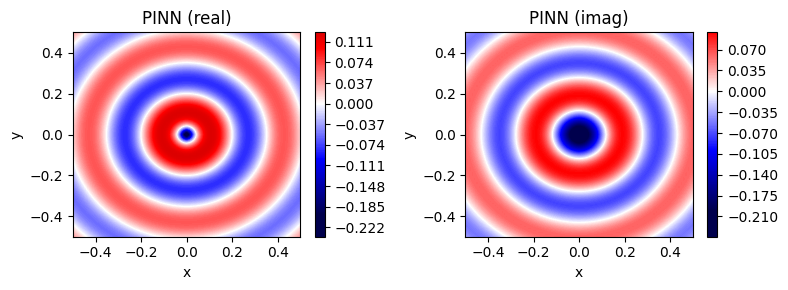

In [6]:
model_pred(model, 0.5, 0.5)

Error(Real) 0.021131213754415512, Error(Imag) 0.02137938141822815


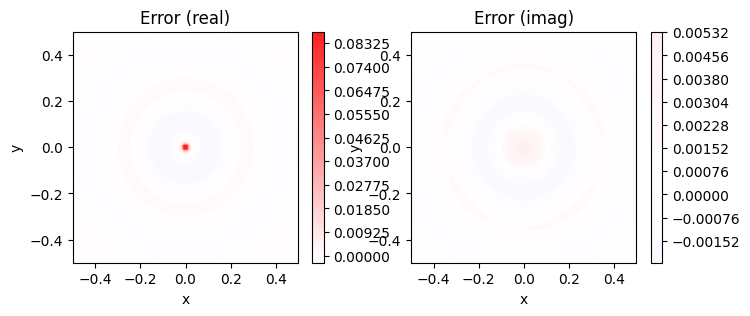

In [7]:
N = 100
k = 20
x, y = torch.linspace(-0.5, 0.5, N), torch.linspace(-0.5, 0.5, N)
x, y = torch.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
model = model.to('cpu')
inputs = torch.cat([x, y], dim=-1)
p_real = model(inputs)[:, 0].detach().numpy()
p_imag = model(inputs)[:, 1].detach().numpy()
p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)

x, y = x.numpy(), y.numpy()
hankel = scipy.special.hankel1(0, k * np.sqrt(x ** 2 + y ** 2) + 1e-6)
p_ref = -0.25j * hankel
p_ref_real, p_ref_imag = p_ref.real.reshape(N, N), p_ref.imag.reshape(N, N)

error_real = p_real - p_ref_real
error_imag = p_imag - p_ref_imag

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_real, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.title('Error (real)')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_imag, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.title('Error (imag)')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('Error.jpg')
print(f"Error(Real) {np.abs(error_real).mean() / np.abs(p_ref_real).mean()}, Error(Imag) {np.abs(error_imag).mean() / np.abs(p_ref_imag).mean()}")


In [8]:
# fixed parameters
L = 1
Lx, Ly = L, L
src = [0, 0]
k = 20

In [9]:
import scipy
x, y = np.linspace(-0.5, 0.5, 200), np.linspace(-0.5, 0.5, 200)
x, y = np.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)

hankel = scipy.special.hankel1(0, k * np.sqrt((x) ** 2 + (y) ** 2))
field = -0.25j * hankel
field = field.reshape(200, 200)
p_ref = field

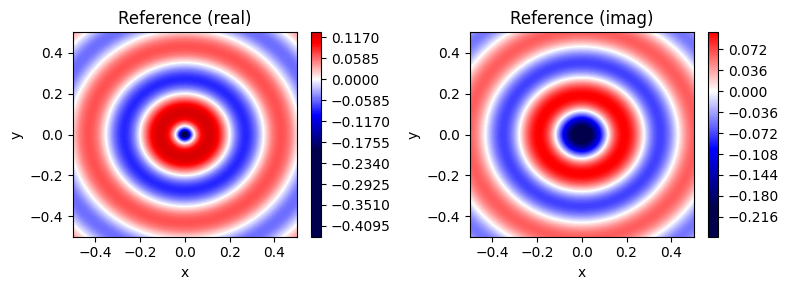

In [10]:
plot_field(field, 0.5, 0.5, bar_max=0.2, title='Reference', filename='Reference')

In [11]:
def plot_loss(l_lst):
    l = np.zeros(len(l_lst))
    i = 0
    for z in l_lst:
        if (i + 1) % 50 == 0:
            l[int(i/50)] = z
            i = i + 1
    plt.plot(np.arange(0, len(l)), l)
    plt.savefig('loss')

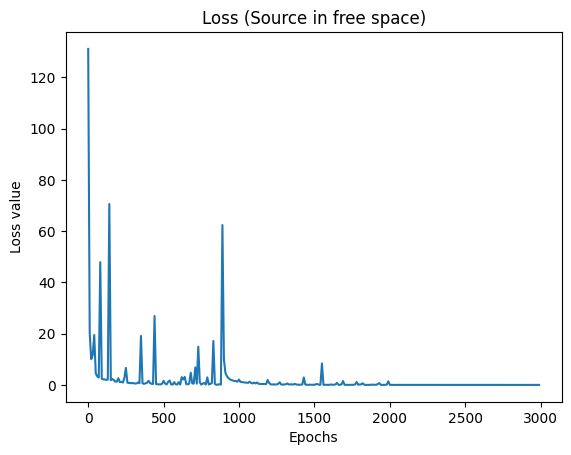

In [19]:
loss = np.load('loss.npy')
loss = loss.tolist()

selected_loss = [loss[i] for i in range(3, len(loss), 10)]

plt.plot(10*np.arange(0, len(selected_loss)), selected_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('Loss (Source in free space)')
plt.savefig('loss')